In [2]:
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np


/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-16 13:35:19.229497: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-16 13:35:19.254504: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-16 13:35:19.518211: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-16 13:35:19.658558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to regis

In [3]:
# Holt alle PDF-Dateien aus dem Ordner "data" (für spätere Verarbeitung)
import glob
pdf_paths = glob.glob("data/*.pdf")  # z. B. ['data/file1.pdf', 'data/file2.pdf', ...]

# Beispiel: Alle PDFs nacheinander durchgehen
for pdf_path in pdf_paths:
    # Hier kannst du jede PDF-Datei einzeln weiterverarbeiten
    print(f"Verarbeite Datei: {pdf_path}")

Verarbeite Datei: data/hypertension-in-adults-diagnosis-and-management (1).pdf
Verarbeite Datei: data/asthma-diagnosis-monitoring-and-chronic-asthma-management (1).pdf


In [4]:
# Öffnet PDF und extrahiert Text aus allen Seiten
with open(pdf_path, "rb") as file:
    reader = PdfReader(file)
    text = "".join(page.extract_text() for page in reader.pages if page.extract_text())

# Zeigt den gesamten extrahierten Text an
print(text)

Asthma: diagnosis, 
moni toring and chr onic 
asthma manag emen t (BTS, 
NICE, SI GN) 
NICE guideline 
Published: 27 No vember 202 4 
www .nice.or g.uk/guidance/ng2 45 
© NICE 202 4. All right s reserved. Subject t o Notice of right s (https://www .nice.or g.uk/t erms-and-
conditions#notice-of -right s).Your r esponsi bility 
The r ecommendations in t his guideline r epresent t he view of NICE, arriv ed at aft er car eful 
consideration of t he evidence a vailable. When e xercising t heir judgement, pr ofessionals 
and practitioners ar e expect ed to tak e this guideline fully int o account, alongside t he 
individual needs, pr eferences and v alues of t heir patient s or t he people using t heir ser vice. 
It is not mandat ory to apply t he recommendations, and t he guideline does not o verride t he 
responsibility t o mak e decisions appr opriat e to the cir cumstances of t he individual, in 
consultation wit h them and t heir f amilies and car ers or guar dian. 
All pr oblems (adv e

In [5]:
## 2. Splitting the Text into Chunks

# Der Text wird mithilfe von LangChain's `RecursiveCharacterTextSplitter` in Abschnitte (Chunks) aufgeteilt.  
# Jeder Abschnitt ist max. 2000 Zeichen lang und überschneidet sich mit dem nächsten um 200 Zeichen, um Kontextübergänge zu erhalten.  
# So entstehen verarbeitbare Einheiten für semantische Analyse, Embeddings oder Retrieval.

# Importiert den Text-Splitter aus LangChain – dieser teilt lange Texte in handhabbare Abschnitte
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Funktion zum Aufteilen eines langen Textes in überlappende Chunks
def split_text_into_chunks(text, chunk_size=2000, overlap=200):
    # Initialisiert den TextSplitter mit gewünschter Chunk-Größe und Überlappung
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,       # Maximale Länge pro Textabschnitt
        chunk_overlap=overlap        # Anzahl Zeichen, die sich zwischen Chunks überschneiden
    )
    # Führt die Aufteilung des Textes durch
    chunks = text_splitter.split_text(text)
    return chunks  # Gibt die Liste der Chunks zurück

# Wendet die Funktion auf den extrahierten PDF-Text an
chunks = split_text_into_chunks(text)

# Gibt die ersten 3 Textabschnitte (Chunks) zur Kontrolle aus
for i, chunk in enumerate(chunks[:3]):
    print(f"Chunk {i+1}:\n{chunk}\n")

# Gibt die Gesamtanzahl der erzeugten Chunks aus
print(f"Gesamtanzahl der Chunks: {len(chunks)}")

Chunk 1:
Asthma: diagnosis, 
moni toring and chr onic 
asthma manag emen t (BTS, 
NICE, SI GN) 
NICE guideline 
Published: 27 No vember 202 4 
www .nice.or g.uk/guidance/ng2 45 
© NICE 202 4. All right s reserved. Subject t o Notice of right s (https://www .nice.or g.uk/t erms-and-
conditions#notice-of -right s).Your r esponsi bility 
The r ecommendations in t his guideline r epresent t he view of NICE, arriv ed at aft er car eful 
consideration of t he evidence a vailable. When e xercising t heir judgement, pr ofessionals 
and practitioners ar e expect ed to tak e this guideline fully int o account, alongside t he 
individual needs, pr eferences and v alues of t heir patient s or t he people using t heir ser vice. 
It is not mandat ory to apply t he recommendations, and t he guideline does not o verride t he 
responsibility t o mak e decisions appr opriat e to the cir cumstances of t he individual, in 
consultation wit h them and t heir f amilies and car ers or guar dian. 
All pr oble

In [6]:
# Diese Zeilen zeigen, wie viele Textabschnitte (Chunks) erstellt wurden,
# und geben eine Vorschau auf die ersten 200 Zeichen des ersten Chunks zur schnellen inhaltlichen Überprüfung.

# Gibt die Gesamtanzahl der erzeugten Textabschnitte (Chunks) aus
print(f"Total chunks: {len(chunks)}")

# Zeigt die ersten 200 Zeichen des ersten Chunks als Vorschau – zur Kontrolle der Aufteilung
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 71
Preview of the first chunk: Asthma: diagnosis, 
moni toring and chr onic 
asthma manag emen t (BTS, 
NICE, SI GN) 
NICE guideline 
Published: 27 No vember 202 4 
www .nice.or g.uk/guidance/ng2 45 
© NICE 202 4. All right s reser


In [7]:
## 3. Tokenizing the Text with Different Tokenizers

# Dieser Text-Splitter teilt den Text nicht nach Zeichen, sondern nach Tokens – basierend auf einem SentenceTransformers-Modell.  
# Jeder Abschnitt enthält maximal 128 Tokens ohne Überlappung.  
# Das Modell `"paraphrase-multilingual-MiniLM-L12-v2"` sorgt für eine sprachübergreifende, sinnvolle Tokenisierung.

# Erstellt einen Token-basierten Text-Splitter, der den Text auf Basis von Token-Anzahl aufteilt
# Nutzt das SentenceTransformers-Modell "paraphrase-multilingual-MiniLM-L12-v2" zur Tokenisierung
token_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=0,                          # Kein Überlapp zwischen den Chunks
    tokens_per_chunk=128,                     # Jeder Chunk enthält max. 128 Tokens
    model_name="paraphrase-multilingual-MiniLM-L12-v2"  # Modell zur Tokenzählung und Split-Logik
)

In [8]:
# Jeder zuvor erzeugte Textabschnitt (Chunk) wird zusätzlich in kleinere Abschnitte aufgeteilt – basierend auf der Token-Anzahl.  
# Dies ermöglicht eine noch feinere, modellgerechte Strukturierung des Texts, z. B. für Embedding oder Retrieval.  
# Am Ende wird die Gesamtzahl der Token-Chunks sowie ein Beispiel ausgegeben.

# Initialisiert eine leere Liste zur Speicherung der tokenbasiert gesplitteten Textabschnitte
token_split_texts = []

# Geht alle Chunks (z. B. aus vorherigem Character-Split) durch und teilt sie weiter in Token-Chunks
for text in chunks:
    # Teilt den Text basierend auf Token-Anzahl (z. B. 128 Tokens pro Abschnitt)
    token_split_texts += token_splitter.split_text(text)

# Gibt die Gesamtanzahl aller erzeugten Token-Chunks aus
print(f"\nTotal chunks: {len(token_split_texts)}")

# Zeigt den ersten Token-basierten Chunk zur Kontrolle
print(token_split_texts[0])


Total chunks: 350
Asthma: diagnosis, moni toring and chr onic asthma manag emen t (BTS, NICE, SI GN) NICE guideline Published: 27 No vember 202 4 www .nice.or g.uk/guidance/ng2 45 © NICE 202 4. All right s reserved. Subject t o Notice of right s (https://www .nice.or g.uk/t erms-and- conditions#notice-of -right s).Your r esponsi bility The r ecommendations in t his guide


In [9]:

# Dieser Abschnitt tokenisiert die ersten 10 Textabschnitte mithilfe eines SentenceTransformer-Modells.  
# Jeder Abschnitt wird in bis zu 128 Tokens umgewandelt, die anschließend auch wieder in lesbare Form zurückkonvertiert werden.  
# So lässt sich prüfen, wie das Modell den Text in Token-Einheiten zerlegt – nützlich für Debugging oder Verständnis.

# Name des vortrainierten SentenceTransformer-Modells zur Tokenisierung
model_name = "paraphrase-multilingual-MiniLM-L12-v2"

# Lädt das Modell inklusive zugehörigem Tokenizer
model = SentenceTransformer(model_name)

# Liste zur Speicherung der tokenisierten Chunks (für spätere Analyse oder Kontrolle)
tokenized_chunks = []

# Durchläuft die ersten 10 token-basierten Textabschnitte
for i, text in enumerate(token_split_texts[:10]):
    
    # Tokenisiert den Text: wandelt ihn in Token-IDs um (max. 128 Tokens, mit Padding und Trunkierung)
    encoded_input = model.tokenizer(
        text,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'  # Gibt ein PyTorch-Tensor-Objekt zurück
    )

    # Wandelt die Token-IDs wieder zurück in lesbare Token-Zeichenketten
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())

    # Speichert die Token in der Liste zur späteren Verwendung oder Analyse
    tokenized_chunks.append(tokens)

    # Gibt die Tokens des aktuellen Chunks zur Kontrolle aus
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁As', 'th', 'ma', ':', '▁', 'diagnos', 'is', ',', '▁moni', '▁to', 'ring', '▁and', '▁chr', '▁on', 'ic', '▁as', 'th', 'ma', '▁mana', 'g', '▁em', 'en', '▁t', '▁(', 'B', 'TS', ',', '▁', 'NICE', ',', '▁SI', '▁', 'GN', ')', '▁', 'NICE', '▁guide', 'line', '▁Published', ':', '▁27', '▁No', '▁v', 'ember', '▁202', '▁4', '▁www', '▁', '.', 'nice', '.', 'or', '▁g', '.', 'uk', '/', 'gui', 'dan', 'ce', '/', 'ng', '2', '▁45', '▁©', '▁', 'NICE', '▁202', '▁4.', '▁All', '▁right', '▁s', '▁reserved', '.', '▁Subject', '▁t', '▁o', '▁No', 'tice', '▁of', '▁right', '▁s', '▁(', 'https', '://', 'www', '▁', '.', 'nice', '.', 'or', '▁g', '.', 'uk', '/', 't', '▁er', 'ms', '-', 'and', '-', '▁conditions', '#', 'no', 'tice', '-', 'of', '▁-', 'right', '▁s', ').', 'You', 'r', '▁r', '▁e', 'spon', 'si', '▁', 'bility', '▁The', '▁r', '▁e', 'com', 'mend', 'ations', '▁in', '▁t', '</s>']
Chunk 1: ['<s>', '▁line', '▁r', '▁e', 'present', '▁t', '▁he', '▁view', '▁of', '▁', 'NICE', ',', '▁arri', 'v', '▁ed', '▁at', '

In [10]:
## 4. Generating Embeddings for Each Chunk

# Der Text wird mithilfe eines multilingualen SentenceTransformer-Modells in Vektorform (Embeddings) umgewandelt.  
# Diese Embeddings erfassen die semantische Bedeutung der Textabschnitte und werden als NumPy-Arrays zurückgegeben. 
# Sie bilden die Grundlage für Ähnlichkeitssuche, Clustering oder Vektordatenbanken wie FAISS.

# Initialisiert ein Embedding-Modell von HuggingFace – wandelt Text in numerische Vektoren um
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")

# Erstellt Embeddings (numerische Repräsentationen) für alle tokenbasierten Textabschnitte
# Die Option convert_to_numpy=True gibt das Ergebnis als NumPy-Array zurück – ideal für weitere Verarbeitung (z. B. FAISS)
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

/tmp/ipykernel_18940/3607705619.py:8: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")


In [11]:
## 5. Building a FAISS Vector Store
# Gibt die Anzahl der Dimensionen eines einzelnen Embedding-Vektors aus (z. B. 384)
d = chunk_embeddings.shape[1]
print(d)

384


In [12]:
# Ein FAISS-Index wird mit L2-Distanz erstellt, um semantische Ähnlichkeit zwischen Embedding-Vektoren zu berechnen.  
# Alle zuvor erzeugten Chunk-Embeddings werden in den Index eingefügt.  
# Am Ende wird geprüft, wie viele Vektoren erfolgreich gespeichert wurden.


# Erstellt einen FAISS-Index mit L2-Distanz (euklidische Distanz) für Vektorsuche
# 'd' ist die Dimension der Embeddings (z. B. 384)
index = faiss.IndexFlatL2(d)

# Fügt alle Embedding-Vektoren (zuvor mit model.encode erzeugt) in den Index ein
index.add(chunk_embeddings)

# Gibt die Anzahl der gespeicherten Vektoren im FAISS-Index aus – zur Kontrolle
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 350


In [13]:
# Der FAISS-Vektorindex wird dauerhaft gespeichert, damit er später erneut geladen werden kann – ohne Neuberechnung.  
# Zusätzlich werden die originalen Text-Chunks als Pickle-Datei gesichert, um bei einer Suche die zugehörigen Texte anzeigen zu können.  
# So bleibt die Verbindung zwischen Embedding-Vektor und Ursprungstext erhalten.


# Speichert den FAISS-Index (mit allen Embeddings) als Datei – zur späteren Wiederverwendung
faiss.write_index(index, "faiss/faiss_index.index")

# Speichert zusätzlich die zugehörigen Text-Chunks (z. B. für spätere Rückverfolgung bei Treffern)
# Die Datei wird im Binärformat (Pickle) geschrieben
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(chunks, f)

In [14]:
# Dieser Code lädt den gespeicherten FAISS-Index sowie die zugehörigen Textabschnitte (Chunks) wieder in den Arbeitsspeicher.  
# Anschließend wird geprüft, ob die Anzahl der geladenen Chunks mit der ursprünglichen Anzahl übereinstimmt – zur Datenintegritätskontrolle.  
# Das stellt sicher, dass Embeddings und Texte korrekt wiederhergestellt wurden.

# Lädt den zuvor gespeicherten FAISS-Index wieder aus der Datei – für Suche oder Weiterverarbeitung
index_2 = faiss.read_index("faiss/faiss_index.index")

# Öffnet die Pickle-Datei und lädt die gespeicherten Text-Chunks wieder (die zu den Embeddings gehören)
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)

# Gibt die Anzahl der geladenen Text-Chunks aus (aus der Pickle-Datei)
print(len(token_split_texts_2))

# Gibt die Anzahl der ursprünglichen Text-Chunks aus (zur Kontrolle)
print(len(token_split_texts))


71
350


In [15]:
## 6. Projecting Embeddings with UMAP

# Ein UMAP-Modell wird auf den Embeddings trainiert, um sie in einen zweidimensionalen Raum zu projizieren – z. B. zur Visualisierung.  
# Die Funktion `project_embeddings()` transformiert neue oder bestehende Embeddings mithilfe des trainierten UMAP-Modells in 2D-Koordinaten.  
# Dadurch lassen sich z. B. semantische Cluster oder inhaltliche Ähnlichkeiten visuell darstellen.

# Trainiert (fit) ein UMAP-Modell auf allen Embedding-Vektoren
# Ziel: Hochdimensionale Embeddings (z. B. 384-D) in 2D-Projektionen für Visualisierung umwandeln
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

# Definiert eine Funktion zur Projektion beliebiger Embeddings auf 2D-Raum mithilfe des vortrainierten UMAP-Modells
def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """

    # Leeres NumPy-Array für die 2D-Koordinaten der projizierten Embeddings
    umap_embeddings = np.empty((len(embeddings), 2))

    # Iteriert über alle Embeddings und wendet die UMAP-Transformation einzeln an
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])  # Einzelprojektion in 2D

    # Gibt die 2D-Embedding-Koordinaten zurück
    return umap_embeddings

/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.python/current/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [16]:
# Alle hochdimensionalen Embeddings werden mit dem trainierten UMAP-Modell in zweidimensionale Vektoren projiziert.  
# Das ermöglicht eine visuelle Darstellung z. B. als Punktwolke oder Cluster-Plot.  
# Die Ausgabe zeigt die Form der 2D-Daten – also wie viele Punkte erzeugt wurden.

# Wendet die UMAP-Projektion auf das gesamte Embedding-Set an (z. B. alle Chunks)
# Ergebnis: Alle hochdimensionalen Vektoren (z. B. 384D) werden in 2D-Koordinaten umgewandelt
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)

# Gibt die Form (Anzahl der Punkte × 2D-Koordinaten) des projizierten Arrays aus
# Beispiel: (500, 2) → 500 Embeddings, jeweils als 2D-Punkt
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/350 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 1/350 [00:02<13:59,  2.41s/it]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/si

Projected dataset embeddings shape: (350, 2)


In [17]:
## 7. Querying the Vector Store and Projecting Results

# Diese Funktion wandelt eine Textanfrage in ein Embedding um und sucht im FAISS-Index nach den k ähnlichsten Chunks.  
# Sie liefert die passenden Textabschnitte, ihre Vektorrepräsentationen und die Ähnlichkeitswerte zurück.  
# Damit bildet sie die Grundlage für semantische Suche in einem vektorisierten Textkorpus.

def retrieve(query, k):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """

    # Wandelt die Benutzeranfrage (query) in einen Embedding-Vektor um
    # → Damit kann sie mit den gespeicherten Chunk-Embeddings verglichen werden
    query_embedding = model.encode([query], convert_to_numpy=True)

    # Sucht im FAISS-Index nach den k ähnlichsten Vektoren (gemessen mit L2-Distanz)
    # Gibt zwei Arrays zurück: Distanzen und die zugehörigen Indexpositionen
    distances, indices = index.search(query_embedding, k)

    # Holt die k zugehörigen Textabschnitte anhand der gefundenen Indizes
    retrieved_texts = [token_split_texts[i] for i in indices[0]]

    # Holt die k zugehörigen Embedding-Vektoren (z. B. für Visualisierung oder weitere Analyse)
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])

    # Gibt: 1) die gefundenen Texte, 2) ihre Embeddings, 3) die Ähnlichkeitswerte (Distanzen)
    return retrieved_texts, retrieved_embeddings, distances[0]

In [18]:
# Eine semantische Suchanfrage wird gestellt und die drei relevantesten Textabschnitte aus dem FAISS-Index zurückgegeben.  
# Die Vorschau zeigt die ersten 300 Zeichen des am ähnlichsten bewerteten Abschnitts.  
# Dies ermöglicht eine schnelle inhaltliche Prüfung der Suchergebnisse.


# Definiert eine Beispielanfrage zur semantischen Suche (z. B. Nutzerfrage in einem Chatbot)
query = "What is the most important stuff for asthma"

# Führt die Retrieval-Funktion aus: sucht die 3 ähnlichsten Textabschnitte zum Query
results, result_embeddings, distances = retrieve(query, k=3)

# Gibt eine Vorschau auf den ersten (am ähnlichsten bewerteten) gefundenen Textabschnitt aus
print("Retrieved document preview:")
print(results[0][:300])  # Zeigt die ersten 300 Zeichen des besten Treffers

Retrieved document preview:
en ag ed 5 to 11 Recommendation 1 .8.1 Asthma: diagnosis, monit oring and chr onic ast hma management (BTS, NICE, SIGN) (NG2 45)


In [19]:
# Die Embeddings der gefundenen Ergebnisse und der ursprünglichen Suchanfrage werden in einen zweidimensionalen Raum projiziert.  
# Dies ermöglicht eine visuelle Darstellung der semantischen Nähe zwischen Query und Treffern, z. B. in einem Streudiagramm.  
# So lässt sich leicht nachvollziehen, ob die Ergebnisse inhaltlich nah an der Anfrage liegen.

# Projiziert die Embeddings der abgerufenen Suchergebnisse (z. B. 3 relevante Chunks) in den 2D-Raum mit UMAP
# → Dient zur Visualisierung der Ähnlichkeiten in einer Plot-Darstellung
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Wandelt die ursprüngliche Benutzeranfrage in ein Embedding um
query_embedding = model.encode([query], convert_to_numpy=True)

# Projiziert auch die Anfrage selbst in denselben 2D-Raum → zur Darstellung im Vergleich zu den Treffern
project_original_query = project_embeddings(query_embedding, umap_transform)

Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]/home/codespace/.local/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings: 100%|██████████| 1/1 [00:00<0

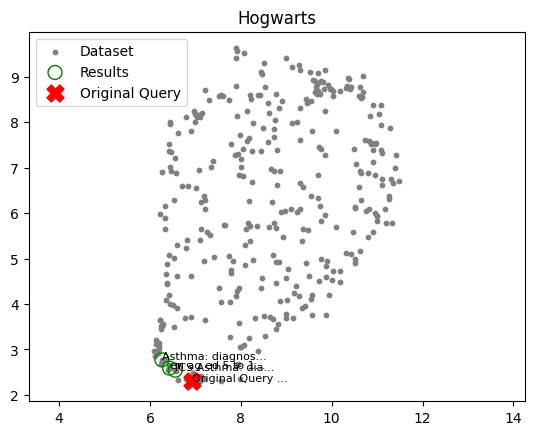

In [20]:
## 8. Visualizing the Results

def shorten_text(text, max_length=15):
    """Kürzt langen Text für Annotationen im Plot (optional mit ...)."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Graue Punkte: das gesamte Embedding-Dataset (alle Chunks)
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')

# Grüne Ringe: die abgerufenen, relevanten Ergebnisse (Suchtreffer)
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')

# Rotes X: die ursprüngliche Suchanfrage
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# Beschriftet jedes Ergebnis mit gekürztem Text
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Beschriftung der ursprünglichen Anfrage
original_query_text = 'Original Query Text'  # → ersetzt ggf. mit: query
plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Hogwarts')  # Titel des Plots (frei wählbar)
plt.legend()
plt.show()